<a href="https://colab.research.google.com/github/alvaradoc/NLP_Topic_Modeling/blob/master/LDA_Topic_Model_on_Gutenberg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Model on Gutenberg Children's books
<br>
## Cynthia Alvarado
### MSDS 7337 Natural Language Processing

The Gutenberg Children's bookshelf consists of 104 books previously used by teachers.  The grade level of the books range from first grade to High School, encompassing a range of text children are exposed to during school.  Some of the books come from Canada, where French is taught in certain regions and the language books are included here too.

I am going to examine the difference in topic model for these books for LDA and LSI using Gensim, as well as sklearn's LDA, LSI and NMF model to examine and contrast the topics included in the children's textbooks.

### What is Topic Modeling?
Topic modeling is used to extract hidden topics on numerous documents, and in this case, textbooks.  In the context of determining topics of school aged children's textbooks, a school district may analyze the topics in a collection of books to find out if the content meets their expectations, then selecting books to recommend to students.  Rather than reading all books, topic modeling can be used to give NLP practitioners a general field of topics the text contains.

### Topic Modeling Algorithms
* Latent Dirichlet Allocation (LDA) is known to be fast and accurate, giving better topic segregation.  The drawback is that it performs best with a large number of documents.

* Latent Semantic Indexing (LSI) also known as Latent Semantic Analysis uses SVD to identify patterins between the terms and the concepts.

* Non-negative Matrix Factorization (NMF) is linear algebra based, and unlike LDA, it can separate topics with a smaller number of documents.

## Load prerequisite packages and Install modules

In [31]:
!pip install gutenberg
!pip install gensim
!pip install pyLDAvis
!python -m spacy download en


    Linking successful
    /usr/local/lib/python2.7/dist-packages/en_core_web_sm -->
    /usr/local/lib/python2.7/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [32]:
from __future__ import division
import platform; print(platform.platform())
import sys; print('Python: ', sys.version)
import math #no version system exist
import nltk; print('NLTK: ', nltk.__version__)
import re; print('Reg Ex: ', re.__version__)
import urllib2; print('URL lib 2: ', urllib2.__version__)
import bs4; print('BS4: ', bs4.__version__)
import pandas as pd; print('Pandas: ', pd.__version__)
from urllib2 import Request, urlopen
from bs4 import BeautifulSoup, SoupStrainer
print 'Gutenberg, 0.7.0 (pypi.org/project/Gutenberg/)' # This library does not come with version function
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import numpy as np; print('Numpy:', np.__version__)
import gensim; print('Gensim:', gensim.__version__)
import gensim.corpora as corpora
import spacy; print('Spacy:', spacy.__version__)
import pyLDAvis; print('pyLDAvis:', pyLDAvis.__version__)
import matplotlib as mpl; print('matplotlib:', mpl.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; print('Seaborn:', sns.__version__)
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import spacy; print('SpaCy:', spacy.__version__)

Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
('Python: ', '2.7.15rc1 (default, Nov 12 2018, 14:31:15) \n[GCC 7.3.0]')
('NLTK: ', '3.2.5')
('Reg Ex: ', '2.2.1')
('URL lib 2: ', '2.7')
('BS4: ', '4.6.3')
('Pandas: ', u'0.22.0')
Gutenberg, 0.7.0 (pypi.org/project/Gutenberg/)
('Numpy:', '1.14.6')
('Gensim:', '3.6.0')
('Spacy:', '2.0.17')
('pyLDAvis:', '2.1.2')
('matplotlib:', '2.1.2')
('Seaborn:', '0.7.1')
('SpaCy:', '2.0.17')


In [33]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en', disable=['parser', 'ner'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Obtain each book's content

In [0]:
bookids = []
raw_book_data = []

url = "http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)"

# create a Request object for gutenberg
req = Request(url)

# download the content
raw = urlopen(req).read()

# convert to unicode string
page = raw.decode("utf-8")

# loop through each link (a href) tag in the raw page
for tag in BeautifulSoup(page, 'html.parser', parse_only=SoupStrainer('a', href=True)):
    # find links with the word 'ebooks' to isolate just the links
    if 'ebooks' in tag['href']:
        newLink = tag['href']
        bookID = int(re.findall('\d+', newLink)[0])
        bookids.append(bookID)
        
for id in bookids:        
    text = strip_headers(load_etext(id)).strip()
    raw_book_data.append(text)



## Remove the Preface

The Gutenberg library will strip the header and footer included in each Gutenberg.org book, but the preface remains.  For this particular analysis, the preface is not considered part of the text to be analized.

In [0]:
data = []
for book in raw_book_data:
    t = book[book.find('CONTENTS'):len(book)]
    data.append(t)

In [36]:
data[0][:200]

u'CONTENTS.\n\nTHE UGLY DUCKLING\nTHE LITTLE PINE TREE\nTHE LITTLE MATCH GIRL\nLITTLE RED RIDING-HOOD\nTHE APPLES OF IDUN\nHOW THOR GOT THE HAMMER\nTHE HAMMER LOST AND FOUND\nTHE STORY OF THE SHEEP\nTHE GOOD SHIP'

## Data Cleanup

This section includes removing stop words, and adding stop words to the NLTK list. We begin by taking 10 topics in which to separate the book list into.

In [0]:


# lemmatized = []
# allowed_postag=['NOUN', 'ADJ', 'VERB', 'ADV']

# for i in range(len(data)):
#    t = clean_text(data[i])
#    doc = nlp(t)
#    lemmatized.append([token.lemma_ for token in doc if token.pos_ in allowed_postag])



In [0]:

STOPWORDS = nltk.corpus.stopwords.words('english')
STOPWORDS = STOPWORDS + ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 
                         'nine', 'ten', 'said', 'mr', 'mrs', 'come', 'go', 'get', 'say', 'ask', 
                         'tell', 'see', 'try', 'back', 'also', 'join', 'find', 'tell', 'listen', 'contents']



def clean_text(text):
  tokenized_text = nltk.word_tokenize(text.lower())
  cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
  return cleaned_text

tokenized_data = []
for text in data:
  tokenized_data.append(clean_text(text))
  


In [38]:
dictionary = corpora.Dictionary(tokenized_data)

corpus = [dictionary.doc2bow(text) for text in tokenized_data]

print corpus[20]

[(0, 23), (1, 7), (2, 24), (3, 50), (4, 43), (5, 26), (6, 37), (7, 37), (8, 1), (9, 14), (10, 60), (11, 16), (12, 24), (13, 1), (14, 4), (15, 4), (16, 8), (20, 35), (21, 44), (23, 24), (24, 7), (25, 3), (26, 89), (27, 3), (28, 13), (29, 2), (30, 5), (31, 1), (32, 3), (34, 36), (35, 41), (36, 21), (37, 50), (38, 2), (39, 51), (40, 37), (41, 7), (42, 1), (43, 34), (44, 28), (46, 3), (47, 18), (48, 2), (49, 2), (50, 11), (51, 12), (52, 8), (53, 1), (54, 9), (55, 18), (57, 12), (58, 100), (59, 25), (61, 1), (62, 10), (63, 14), (64, 23), (65, 21), (66, 1), (67, 4), (68, 24), (69, 11), (71, 9), (72, 13), (73, 16), (74, 27), (75, 1), (80, 6), (81, 4), (82, 4), (83, 7), (84, 1), (85, 10), (87, 5), (90, 53), (91, 79), (92, 3), (94, 7), (95, 4), (96, 6), (97, 1), (98, 14), (99, 9), (100, 10), (101, 15), (102, 43), (103, 1), (104, 25), (105, 2), (106, 1), (107, 27), (108, 2), (109, 4), (110, 16), (111, 9), (113, 27), (116, 23), (117, 15), (118, 8), (119, 3), (121, 10), (122, 101), (123, 23), (126

## Build LDA and LSI with Gensim

In [0]:
NUM_TOPICS = 10

lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

lsi_model = gensim.models.LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

Below, we see the output of each topic, separated by topic model algorithm.  Each topic is a combination of keywords, and each keyword has a weight for which it contributes to the topic.

In [40]:
print "LDA Model:"
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print "Topic #%s:" % idx, lda_model.print_topic(idx, 10)
 
print "=" * 20
 
print "LSI Model:"
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print "=" * 20

LDA Model:
Topic #0: 0.004*"made" + 0.004*"would" + 0.003*"little" + 0.003*"time" + 0.003*"may" + 0.003*"great" + 0.003*"make" + 0.002*"water" + 0.002*"like" + 0.002*"well"
Topic #1: 0.005*"little" + 0.004*"would" + 0.004*"made" + 0.004*"great" + 0.003*"first" + 0.003*"like" + 0.003*"long" + 0.003*"man" + 0.003*"time" + 0.003*"water"
Topic #2: 0.005*"would" + 0.005*"little" + 0.004*"like" + 0.004*"time" + 0.003*"old" + 0.003*"could" + 0.003*"great" + 0.003*"never" + 0.003*"many" + 0.003*"upon"
Topic #3: 0.005*"great" + 0.003*"little" + 0.003*"would" + 0.003*"time" + 0.003*"upon" + 0.003*"may" + 0.003*"like" + 0.003*"made" + 0.003*"first" + 0.002*"old"
Topic #4: 0.005*"would" + 0.004*"great" + 0.003*"little" + 0.003*"made" + 0.003*"time" + 0.003*"man" + 0.003*"may" + 0.002*"like" + 0.002*"upon" + 0.002*"many"
Topic #5: 0.004*"made" + 0.003*"would" + 0.003*"great" + 0.003*"like" + 0.003*"little" + 0.003*"time" + 0.002*"man" + 0.002*"many" + 0.002*"upon" + 0.002*"could"
Topic #6: 0.004*"g

## Perplexity and Coherence Score



In [41]:
# Compute Perplexity
print '\nPerplexity: ', lda_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print '\nCoherence Score: ', coherence_lda


Perplexity:  -9.535323651957604

Coherence Score:  0.33338174196964265


Here, a low perplexity score is good, as you want the lowest possible perplexity score for your model.  However, it looks like the coherence score is quite low as well.  Generally, the higher the coherence score, the better the model because it gives a gauge of how well the model can interpret the topics.

## Visualizing the LDA Model

In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      26.343208        1       1 -0.006131 -0.001093
6      25.084431        1       2 -0.005502  0.001786
3      11.157248        1       3 -0.000287 -0.003618
1       9.218985        1       4  0.001927 -0.003175
9       7.217498        1       5 -0.001723 -0.001653
4       6.401826        1       6  0.004703  0.000291
8       5.879327        1       7 -0.003489  0.000579
0       3.554596        1       8  0.004826 -0.003007
7       3.411505        1       9 -0.000718  0.006007
5       1.731375        1      10  0.006394  0.003884, topic_info=      Category         Freq    Term        Total  loglift  logprob
term                                                              
62171  Default  4906.000000    made  4906.000000  30.0000  30.0000
15721  Default  7369.000000   would  7369.000000  29.0000  29.0000
66297  Default  6459.000000   great  6459.000000  28.0000  28.0000
53660  Default  7445.000000  little  7445.000000  27.0000  27.0000
71718  Default  4812.000000     may  4812.000000  26.0000  26.0000
15279  Default  5697.000000    like  5697.000000  25.0000  25.0000
4356   Default  5365.000000   could  5365.000000  24.0000  24.0000
53453  Default  4617.000000     man  4617.000000  23.0000  23.0000
63578  Default  5984.000000    time  5984.000000  22.0000  22.0000
43596  Default  4022.000000    many  4022.000000  21.0000  21.0000
52760  Default  3763.000000    make  3763.000000  20.0000  20.0000
75609  Default  3614.000000    good  3614.000000  19.0000  19.0000
12155  Default  4064.000000   first  4064.000000  18.0000  18.0000
67047  Default  4610.000000    upon  4610.000000  17.0000  17.0000
19404  Default  4392.000000    long  4392.000000  16.0000  16.0000
79262  Default  3397.000000   water  3397.000000  15.0000  15.0000
51461  Default  3400.000000    well  3400.000000  14.0000  14.0000
78071  Default  3383.000000    must  3383.000000  13.0000  13.0000
76920  Default  3836.000000     day  3836.000000  12.0000  12.0000
5935   Default  3014.000000    away  3014.000000  11.0000  11.0000
54993  Default  2157.000000    part  2157.000000  10.0000  10.0000
31339  Default  3047.000000     new  3047.000000   9.0000   9.0000
63344  Default  4480.000000     old  4480.000000   8.0000   8.0000
47845  Default  3379.000000     way  3379.000000   7.0000   7.0000
58815  Default  2571.000000   place  2571.000000   6.0000   6.0000
52140  Default  3387.000000   every  3387.000000   5.0000   5.0000
42152  Default  3627.000000    came  3627.000000   4.0000   4.0000
10473  Default  3314.000000     men  3314.000000   3.0000   3.0000
21728  Default  2768.000000    life  2768.000000   2.0000   2.0000
21931  Default  2798.000000  people  2798.000000   1.0000   1.0000
...        ...          ...     ...          ...      ...      ...
43596  Topic10    70.601349    many  4022.369629   0.0137  -6.0801
28371  Topic10    25.567444    read  1091.066406   0.3027  -7.0958
15279  Topic10    89.911240    like  5697.480469  -0.0927  -5.8383
36634  Topic10    33.810654     end  1578.616089   0.2127  -6.8163
1643   Topic10    45.215572   years  2330.510986   0.1139  -6.5257
15721  Topic10   107.141144   would  7369.464355  -0.1747  -5.6630
78071  Topic10    59.623238    must  3383.630615   0.0176  -6.2491
52760  Topic10    64.384872    make  3763.979004  -0.0121  -6.1722
53453  Topic10    74.856216     man  4617.127441  -0.0657  -6.0216
67047  Topic10    70.548782    upon  4610.196289  -0.1235  -6.0808
6222   Topic10    38.910194   night  1998.320557   0.1174  -6.6759
20480  Topic10    29.874409    thus  1375.827637   0.2264  -6.9401
63578  Topic10    79.912384    time  5984.705078  -0.2598  -5.9562
71718  Topic10    69.004440     may  4812.515137  -0.1886  -6.1030
75609  Topic10    56.921730    good  3614.416504  -0.0948  -6.2954
4356   Topic10    70.116440   could  5365.219727  -0.2813  -6.0870
31339  Topic10    48.94012

On the left, each disk represents a unique LDA topic.  The larger, the more prevalent the topic.  Good models will have large, non-overlapping disks rather than clustered in a particular quadrant.  The bars to the right get updated with the words within the topic, with the bar in red to represent the estimated term frequency within the selected topic.

Further, topics close to one another are more similar to topics spaced further away.

## LDA, LSI and NMF with Sklearn

In [43]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 10
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words=STOPWORDS, lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(data)
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(data_vectorized)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
 
# Let's see how the first document in the corpus looks like in different topic spaces
print("\n")
print(lda_Z[0])
print("\n")
print(nmf_Z[0])
print("\n")
print(lsi_Z[0])

(104, 10)
(104, 10)
(104, 10)


[2.99615831e-05 2.99602473e-05 2.99645166e-05 2.99619613e-05
 2.99631818e-05 9.99730341e-01 2.99635095e-05 2.99620102e-05
 2.99615670e-05 2.99601458e-05]


[2.18935586 0.         0.         0.         0.03738282 0.
 0.         0.         0.         0.        ]


[108.02871976 -50.80769699  -7.43435927  42.73039852  14.47363848
 -16.32899505  -9.11432933   0.22368914 -41.1197979  -33.21491444]


## Model Output

In [44]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda_model, vectorizer)
print("=" * 20)
 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 
print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[(u'would', 46.540849189671235), (u'great', 44.620624584744), (u'little', 43.739388546725145), (u'time', 33.15863858244364), (u'could', 31.475048083074814), (u'like', 30.67172257330646), (u'day', 30.556781409268034), (u'man', 28.393646122302588), (u'may', 27.948277323183813), (u'made', 27.817960079340587)]
Topic 1:
[(u'great', 20.438489174739825), (u'would', 15.013703469816715), (u'time', 14.696005936773428), (u'could', 13.28791242282772), (u'made', 12.969052952051769), (u'much', 11.39250996613549), (u'well', 10.577767218940313), (u'man', 10.437228330915968), (u'every', 10.094426128266786), (u'many', 9.888619223099333)]
Topic 2:
[(u'would', 3004.2225658867483), (u'great', 2576.478343659324), (u'man', 2393.6721680170326), (u'little', 2206.084708790723), (u'could', 2205.994638241834), (u'upon', 2079.578916855474), (u'time', 2048.4485842638783), (u'like', 2021.5270388859724), (u'made', 1950.0156419450811), (u'old', 1662.115928701624)]
Topic 3:
[(u'states', 1107.2960644

## SVD Plot of LSI

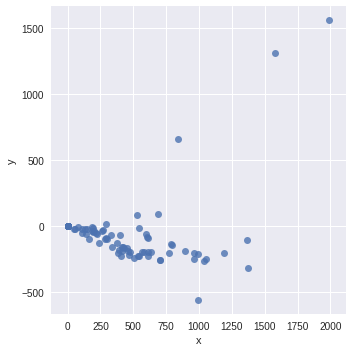

In [46]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 

# plt.scatter(df['x'], df['y'], alpha=0.8)
# plt.show()

ax = sns.lmplot('x', 'y', data=df, fit_reg=False)

## Conclusion

Each package used, that is Gensim or SKLearn returned topics with overlapping words.  Because the text was for school aged children spanning from first grade to high school, I expected that the topics would cover more variety.  Instead, each returned topics with overlapping words.  Given the list of words, the prevalent topics for these books are stories for younger children, with more common words used and the word "little" appearing frequently, and overlaps with multiple topcs.
<br><br>

For future work, standardizing the text with lemmatization should remove different forms of the words and condense it.  Further, future work on adjusting the models is needed, such as adjusting the alpha values for LDA, or reducing the number of topics.  I also noted that the LSI model picked up a foreign language text.  It would be interesting to pick out the language, and get that language module to lemmatize that text as well.  From a cursory view, it looks like the foreign language text contained stop words from that language.  It was hard for me to discern the language, but I narrowed it to either Spanish or Italian.  

## References

* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://nlpforhackers.io/topic-modeling/
* https://rare-technologies.com/what-is-topic-coherence/
* Ben Brock's iPython notebooks
* https://cfss.uchicago.edu/fall2016/text02.html
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/